#Imports

INSTALL MORE RECENT LIGHTGBM VERSION

In [ ]:
!pip install optuna &> /dev/null

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM &> /dev/null


In [ ]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu &> /dev/null


-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Found Boost: /usr/include (found suitable version "1.65.1", minimum required is "1.56.0") found components: filesystem system 
-- Performing Test MM_PREFET

In [ ]:
import lightgbm as lgbm

In [ ]:
print(lgbm.__version__) # check version to be sure.

3.3.2.99


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
#import lightgbm # this imports lightgbm version 2.2.3, which does not support some pretty nice features.
import matplotlib.pyplot as plt
from math import log10
from collections import Counter
from sklearn import preprocessing
from optuna.integration import LightGBMPruningCallback
import optuna

#Loading and checking data

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
df = pd.read_csv('drive/MyDrive/training_set_VU_DM.csv')#, nrows=3500000)

In [ ]:
df['price_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird. replace with 0.1 for the log function
df['price_usd'] = df['price_usd'].apply(log10)

df['visitor_hist_adr_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird.
df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].apply(log10)

In [ ]:
### feature which highlights difference between the visitors historical data and the hotel cost
df['usd_diff'] = np.abs(df.visitor_hist_adr_usd.values - df.price_usd.values)
df['star_diff'] = np.abs(df.visitor_hist_starrating.values - df.prop_starrating.values)

Code below adds a ranking based on the price_usd feature, seems to decrease/keep performance the same

In [ ]:
df_test = pd.read_csv('drive/MyDrive/test_set_VU_DM.csv')#, nrows=1000000)

In [ ]:
df_test['price_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird. replace with 0.1 for the log function
df_test['price_usd'] = df_test['price_usd'].apply(log10)

df_test['visitor_hist_adr_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird.
df_test['visitor_hist_adr_usd'] = df_test['visitor_hist_adr_usd'].apply(log10)

In [ ]:
### feature which highlights difference between the visitors historical data and the hotel cost
df_test['usd_diff'] = np.abs(df_test.visitor_hist_adr_usd.values - df_test.price_usd.values)
df_test['star_diff'] = np.abs(df_test.visitor_hist_starrating.values - df_test.prop_starrating.values)

creating new features based on click and booking booleans. DID NOT USE THIS FOR THE FINAL MODEL, PERFORMS NOT WELL

In [ ]:
### more custom features, based on clicking and booking booleans ### 
all_prop_id_counts = df.prop_id.value_counts()
prop_id_counts = all_prop_id_counts.to_dict()
prop_id_counts = Counter(prop_id_counts) # dictionary with the total number of times every prop id exists

booking_df = df.drop(df[df.booking_bool == 0].index)
booking_df = booking_df.groupby(["prop_id", "booking_bool"]).size().reset_index(name="occurences")
booking_df = booking_df.drop(['booking_bool'], axis=1).set_index('prop_id')
booking_occurences = booking_df.squeeze().to_dict()
booking_occurences = Counter(booking_occurences) # dictionary with number of times each property was booked

clicking_df = df.drop(df[df.click_bool == 0].index)

clicking_df = clicking_df.groupby(['prop_id', 'click_bool']).size().reset_index(name="occurences")
clicking_df = clicking_df.drop(['click_bool'], axis=1).set_index('prop_id')
clicking_occurences = clicking_df.squeeze().to_dict()
clicking_occurences = Counter(clicking_occurences) # dictionary with number of times each property was clicked

book_div_count = {k: booking_occurences[k]/prop_id_counts[k] for k in prop_id_counts.keys() & booking_occurences} # bookings divided by total occurences
click_div_count = {k: clicking_occurences[k]/prop_id_counts[k] for k in prop_id_counts.keys() & clicking_occurences} # clicks divided by total occurences

### making and merging dataframes from the score dictionaries (right above this), thanks piotr
book_score_df_from_dict = pd.DataFrame(book_div_count.items())
book_score_df_from_dict.columns = ['prop_id', 'book_score']
click_score_df_from_dict = pd.DataFrame(click_div_count.items())
click_score_df_from_dict.columns = ['prop_id', 'click_score']

df = pd.merge(df,book_score_df_from_dict, how='left', left_on='prop_id', right_on='prop_id')
df = pd.merge(df,click_score_df_from_dict, how='left', left_on='prop_id', right_on='prop_id')

df['click_score'] = df['click_score'].fillna(0) # i fill nans with 0 here, could keep them and turn to -10 later, compare performane with eval set
df['book_score'] = df['book_score'].fillna(0)

df['click_score'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['click_score']).reshape(-1,1))
df['book_score'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['book_score']).reshape(-1,1))

# clearing unnecesary variables to save memory space
del all_prop_id_counts, prop_id_counts, booking_df, booking_occurences, clicking_df, clicking_occurences, book_div_count, click_div_count

In [ ]:
del df

We also want to add these click and book scores to the test set, because otherwise we cant make predictions. DID NOT USE THIS BECAUSE PERFORMS BAD

In [ ]:
df_test = pd.merge(df_test,book_score_df_from_dict, how='left', left_on='prop_id', right_on='prop_id')
df_test = pd.merge(df_test,click_score_df_from_dict, how='left', left_on='prop_id', right_on='prop_id')

df_test['click_score'] = df_test['click_score'].fillna(0) # i fill nans with 0 here, could keep them and turn to -10 later, compare performane with eval set
df_test['book_score'] = df_test['book_score'].fillna(0)

df_test['click_score'] = preprocessing.MinMaxScaler().fit_transform(np.array(df_test['click_score']).reshape(-1,1))
df_test['book_score'] = preprocessing.MinMaxScaler().fit_transform(np.array(df_test['book_score']).reshape(-1,1))

#Making Training and evaluation data for the model

Adding mean property price as a feature to dataset

In [ ]:
def get_from_dict(x, _dict):
    '''There might be a better way to do this'''
    return _dict[x]

def add_mean_of_feature(df, feature, average_over):
  same_vals_df = pd.DataFrame()
  _dict = df.groupby(average_over)[feature].mean().to_dict()
  same_vals_df['same_val_'+average_over+'_'+feature+'_'+'avg'] = df[average_over].apply(get_from_dict, _dict=_dict)
  df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)
  return df

def add_std_of_feature(df, feature, average_over):
  same_vals_df = pd.DataFrame()
  _dict = df.groupby(average_over)[feature].std().to_dict()
  same_vals_df['same_val_'+average_over+'_'+feature+'_'+'std'] = df[average_over].apply(get_from_dict, _dict=_dict)
  df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)
  return df


Here we use the above defined functions to add mean and std of features per prop id and srch id.  

In [ ]:
df = add_mean_of_feature(df, 'price_usd', 'srch_id')
df = add_std_of_feature(df, 'price_usd', 'srch_id')
df = add_mean_of_feature(df, 'price_usd', 'prop_id')
df = add_std_of_feature(df, 'price_usd', 'prop_id')

df = add_mean_of_feature(df, 'prop_log_historical_price', 'srch_id')
df = add_std_of_feature(df, 'prop_log_historical_price', 'srch_id')
df = add_mean_of_feature(df, 'prop_log_historical_price', 'prop_id')
df = add_std_of_feature(df, 'prop_log_historical_price', 'prop_id')

df = add_mean_of_feature(df, 'prop_location_score1', 'srch_id')
df = add_std_of_feature(df, 'prop_location_score1', 'srch_id')
df = add_mean_of_feature(df, 'prop_location_score1', 'prop_id')
df = add_std_of_feature(df, 'prop_location_score1', 'prop_id')

df = add_mean_of_feature(df, 'prop_location_score2', 'srch_id')
df = add_std_of_feature(df, 'prop_location_score2', 'srch_id')
df = add_mean_of_feature(df, 'prop_location_score2', 'prop_id')
df = add_std_of_feature(df, 'prop_location_score2', 'prop_id')

df = add_mean_of_feature(df, 'prop_review_score', 'srch_id')
df = add_std_of_feature(df, 'prop_review_score', 'srch_id')
df = add_mean_of_feature(df, 'prop_review_score', 'prop_id')
df = add_std_of_feature(df, 'prop_review_score', 'prop_id')

for test set

In [ ]:
df_test = add_mean_of_feature(df_test, 'price_usd', 'srch_id')
df_test = add_std_of_feature(df_test, 'price_usd', 'srch_id')
df_test = add_mean_of_feature(df_test, 'price_usd', 'prop_id')
df_test = add_std_of_feature(df_test, 'price_usd', 'prop_id')

df_test = add_mean_of_feature(df_test, 'prop_log_historical_price', 'srch_id')
df_test = add_std_of_feature(df_test, 'prop_log_historical_price', 'srch_id')
df_test = add_mean_of_feature(df_test, 'prop_log_historical_price', 'prop_id')
df_test = add_std_of_feature(df_test, 'prop_log_historical_price', 'prop_id')

df_test = add_mean_of_feature(df_test, 'prop_location_score1', 'srch_id')
df_test = add_std_of_feature(df_test, 'prop_location_score1', 'srch_id')
df_test = add_mean_of_feature(df_test, 'prop_location_score1', 'prop_id')
df_test = add_std_of_feature(df_test, 'prop_location_score1', 'prop_id')

df_test = add_mean_of_feature(df_test, 'prop_location_score2', 'srch_id')
df_test = add_std_of_feature(df_test, 'prop_location_score2', 'srch_id')
df_test = add_mean_of_feature(df_test, 'prop_location_score2', 'prop_id')
df_test = add_std_of_feature(df_test, 'prop_location_score2', 'prop_id')

df_test = add_mean_of_feature(df_test, 'prop_review_score', 'srch_id')
df_test = add_std_of_feature(df_test, 'prop_review_score', 'srch_id')
df_test = add_mean_of_feature(df_test, 'prop_review_score', 'prop_id')
df_test = add_std_of_feature(df_test, 'prop_review_score', 'prop_id')

In [ ]:
### so i want to fill the competition NaN values with 0s
### all other variables i will set NaNs to -10
comp_columnns = [comp_col for comp_col in df.columns if comp_col.startswith('comp')]
df[comp_columnns] = df[comp_columnns].fillna(0)
df = df.fillna(-10)

for test set!

In [ ]:
comp_columnns = [comp_col for comp_col in df_test.columns if comp_col.startswith('comp')]
df_test[comp_columnns] = df_test[comp_columnns].fillna(0)
df_test = df_test.fillna(-10)
df_test = df_test.drop(['date_time', 'site_id', 'random_bool', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1, inplace=False)

In [ ]:
df_train = df[:4000000]
df_eval = df[4000000:]

qids_train = df_train.groupby('srch_id')['srch_id'].count().to_numpy()
y_train = 5 * df_train['booking_bool'].values + df_train['click_bool'].values # booking_bool weighs for 5, clicking bool for 1
X_train = df_train.drop(['date_time', 'random_bool', 'click_bool', 'booking_bool', 'position', 'site_id', 'gross_bookings_usd', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1) # 

qids_eval = df_eval.groupby('srch_id')['srch_id'].count().to_numpy()
y_eval = 5 * df_eval['booking_bool'].values + df_eval['click_bool'].values
X_eval = df_eval.drop(['date_time', 'random_bool', 'click_bool', 'booking_bool', 'position', 'site_id', 'gross_bookings_usd', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1) # 

In [ ]:
del df, df_train, df_eval

#Training a simple lightgbm model with the objective lambdaRank

In [ ]:
del X_train, y_train, qids_train # delete from memory after training to prevent runtime crashes and restarts 


hyperparameter optuna optimization, really slow on colab.. trying to run locally

In [ ]:
def objective(trial, X_train, y_train, X_eval, y_eval):
    param_grid = {
        "num_leaves": trial.suggest_int("num_leaves", 100, 200, step=20),
        "max_depth": trial.suggest_int("max_depth", -1, 11, step=3),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9, step=0.1),
        "bagging_freq": trial.suggest_int('bagging_freq', 0, 5, step=1),
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 1, step=0.1)
    }
    
    model = lgbm.LGBMRanker(objective="lambdarank", metric='ndcg', boosting='dart', 
    n_estimators=130, learning_rate=0.2493,
    min_data_in_leaf=1, min_sum_hessian_in_leaf=150,
    drop_rate=0.46, max_drop=50, skip_drop=0.8, uniform_drop=False, xgboost_dart_mode=False,
    **param_grid)

    model.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set =[(X_eval, y_eval)],
        eval_group=[qids_eval],
        eval_at=5,
    )
    return model.best_score_['valid_0']['ndcg@5']

study = optuna.create_study(direction="maximize", study_name="LGBM Ranker")
func = lambda trial: objective(trial, X_train=X_train, y_train=y_train, X_eval=X_eval, y_eval=y_eval)
study.optimize(func, n_trials=50)

print(f"\tBest value (ndcg@5): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


'''
Best is trial 88 with value: 0.3762362113856716.
        Best value (ndcg@5): 0.37624
        Best params:
                n_estimators: 130
                learning_rate: 0.24930770064423344
                num_leaves: 150
                max_depth: 6
                min_data_in_leaf: 1
                min_sum_hessian_in_leaf: 150
                bagging_fraction: 0.8
                bagging_freq: 1
                feature_fraction: 0.8
'''
'''
Best is trial 20 with value: 0.3766652781645998.
        Best value (ndcg@5): 0.37667
        Best params:
                drop_rate: 0.46
                max_drop: 60
                skip_drop: 0.8
                xgboost_dart_mode: False
                uniform_drop: False
'''
'''
76044.
        Best value (ndcg@5): 0.39283
        Best params:
                num_leaves: 200
                bagging_fraction: 0.8
                bagging_freq: 0
'''

[I 2022-05-23 13:42:40,101] A new study created in memory with name: LGBM Ranker


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=150, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, s

[I 2022-05-23 13:58:23,207] Trial 0 finished with value: 0.40049738985034716 and parameters: {'num_leaves': 120, 'max_depth': 11, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'feature_fraction': 1.0}. Best is trial 0 with value: 0.40049738985034716.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=150, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, s

[I 2022-05-23 14:12:36,422] Trial 1 finished with value: 0.3966525544129485 and parameters: {'num_leaves': 160, 'max_depth': 8, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.40049738985034716.


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=150, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, s

[I 2022-05-23 14:17:47,501] Trial 2 finished with value: 0.379045536725519 and parameters: {'num_leaves': 120, 'max_depth': 2, 'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.6}. Best is trial 0 with value: 0.40049738985034716.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=150, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, s

[I 2022-05-23 14:22:27,238] Trial 3 finished with value: 0.3786339861575568 and parameters: {'num_leaves': 160, 'max_depth': 2, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.40049738985034716.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=150, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, s

KeyboardInterrupt: ignored

In [ ]:
### original model, parameters = score of ¬ 0.399

model = lgbm.LGBMRanker(objective='lambdarank', metric='ndcg', boosting='dart',
                        num_leaves=110, min_data_in_leaf=1, min_sum_hessian_in_leaf=200, n_estimators=1000,
                        num_iterations=1000, learning_rate=0.08, early_stopping_rounds=65, device_type='cpu', seed=42)
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train)
''',
    eval_set=[(X_eval, y_eval)],
    eval_group=[qids_eval],
    eval_at=[5, 38],
)
'''

# want to try: 
# boosting='gdbt' with learning rate=0.04 with all newly constructed features -> 0.389 on kaggle -> want to try gbdt with all features except click and book scores maybe
# boosting='dart' with learning rate=0.04 with all newly constructed features -> 0.388 on kaggle -> overfitting?
# min_data_in_leaf=20 -> compare with gbdt 1 vs 20 -> no difference observed
# note: lower num_leaves might actually be better -> try dart with ~110 leaves seems best from tests
# tree_learner='voting' or 'parallel' -> doesnt do much in tests
# increase learning rate from 0.03 -> 0.1 or even 0.2?
# play around with dart parameters -> don't seem to influence performance very much

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:136: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=200, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=65, early_stopping_rounds=65 will be ignored. Current value: early_stopping_round=65
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=200, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.639740 seconds.
You can set `force_row_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:265: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


',\n    eval_set=[(X_eval, y_eval)],\n    eval_group=[qids_eval],\n    eval_at=[5, 38],\n)\n'

In [ ]:
model.booster_.save_model('drive/MyDrive/dart_110_leaves.txt')


model which scored 0.39207: mode.txt
model which scored 0.40101: mode_test.txt
gbdt test model = gbdt_test.txt
same as the 0.40101 but with 2 additional click and bool scores = dart_21-05.txt
dart_110_leaves.txt: 

In [ ]:
model = lgbm.Booster(model_file='drive/MyDrive/dart_110_leaves.txt')  # init model

In [ ]:
del df, df_eval,df_train,qids_eval, same_vals_df, qids_train , X_eval, X_train, y_eval, y_train # delete from memory after training to prevent runtime crashes and restarts 
#del df_test, X_test, results]


#Making predictions to rank prop_ids by srch_ids

THIS IS FOR THE lightGBM MODEL

In [ ]:
results = model.predict(df_test)
print(len(results.tolist()))

4959183


##making new dataframe to eventually export to csv

In [ ]:
new_df = df_test[['prop_id', 'srch_id']]
new_df['predictions'] = results
print(new_df.head(30))

    prop_id  srch_id  predictions
0      3180        1     0.131952
1      5543        1     0.095996
2     14142        1    -0.604959
3     22393        1    -0.562811
4     24194        1     0.456532
5     28181        1     0.455959
6     34263        1     0.435934
7     37567        1    -0.416906
8     50162        1     0.054956
9     54937        1     0.770378
10    56050        1    -1.357556
11    61632        1    -1.939401
12    61934        1     0.843411
13    63894        1    -0.016628
14    72090        1    -0.358081
15    73666        1    -0.762820
16    74045        1    -0.070768
17    78599        1     0.009851
18    82231        1     0.045022
19    89466        1    -0.697473
20    90385        1     0.250092
21    94729        1    -0.378087
22    95031        1     0.329900
23    99484        1     0.898975
24   123675        1    -0.254764
25   128085        1    -0.332184
26   128871        1    -0.884870
27   134992        1    -1.410911
28   139162   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sorted_df = new_df.sort_values(['srch_id', 'predictions'], ascending=[True, False])
print(sorted_df.head(30))

    prop_id  srch_id  predictions
23    99484        1     0.898975
12    61934        1     0.843411
9     54937        1     0.770378
4     24194        1     0.456532
5     28181        1     0.455959
6     34263        1     0.435934
22    95031        1     0.329900
20    90385        1     0.250092
0      3180        1     0.131952
1      5543        1     0.095996
8     50162        1     0.054956
18    82231        1     0.045022
17    78599        1     0.009851
13    63894        1    -0.016628
16    74045        1    -0.070768
24   123675        1    -0.254764
25   128085        1    -0.332184
14    72090        1    -0.358081
21    94729        1    -0.378087
7     37567        1    -0.416906
3     22393        1    -0.562811
2     14142        1    -0.604959
19    89466        1    -0.697473
15    73666        1    -0.762820
26   128871        1    -0.884870
28   139162        1    -1.041877
10    56050        1    -1.357556
27   134992        1    -1.410911
11    61632   

Export the predictions csv


In [ ]:
export_df = sorted_df.drop(['predictions'], axis=1)
export_df = export_df[['srch_id', 'prop_id']] # swap columns for required format

compression_opts = dict(method='zip', archive_name='out.csv')  
export_df.to_csv('out.zip', index=False, compression=compression_opts) # we can submit .zip instead of the raw .csv, which saves some space.

In [ ]:
%matplotlib inline

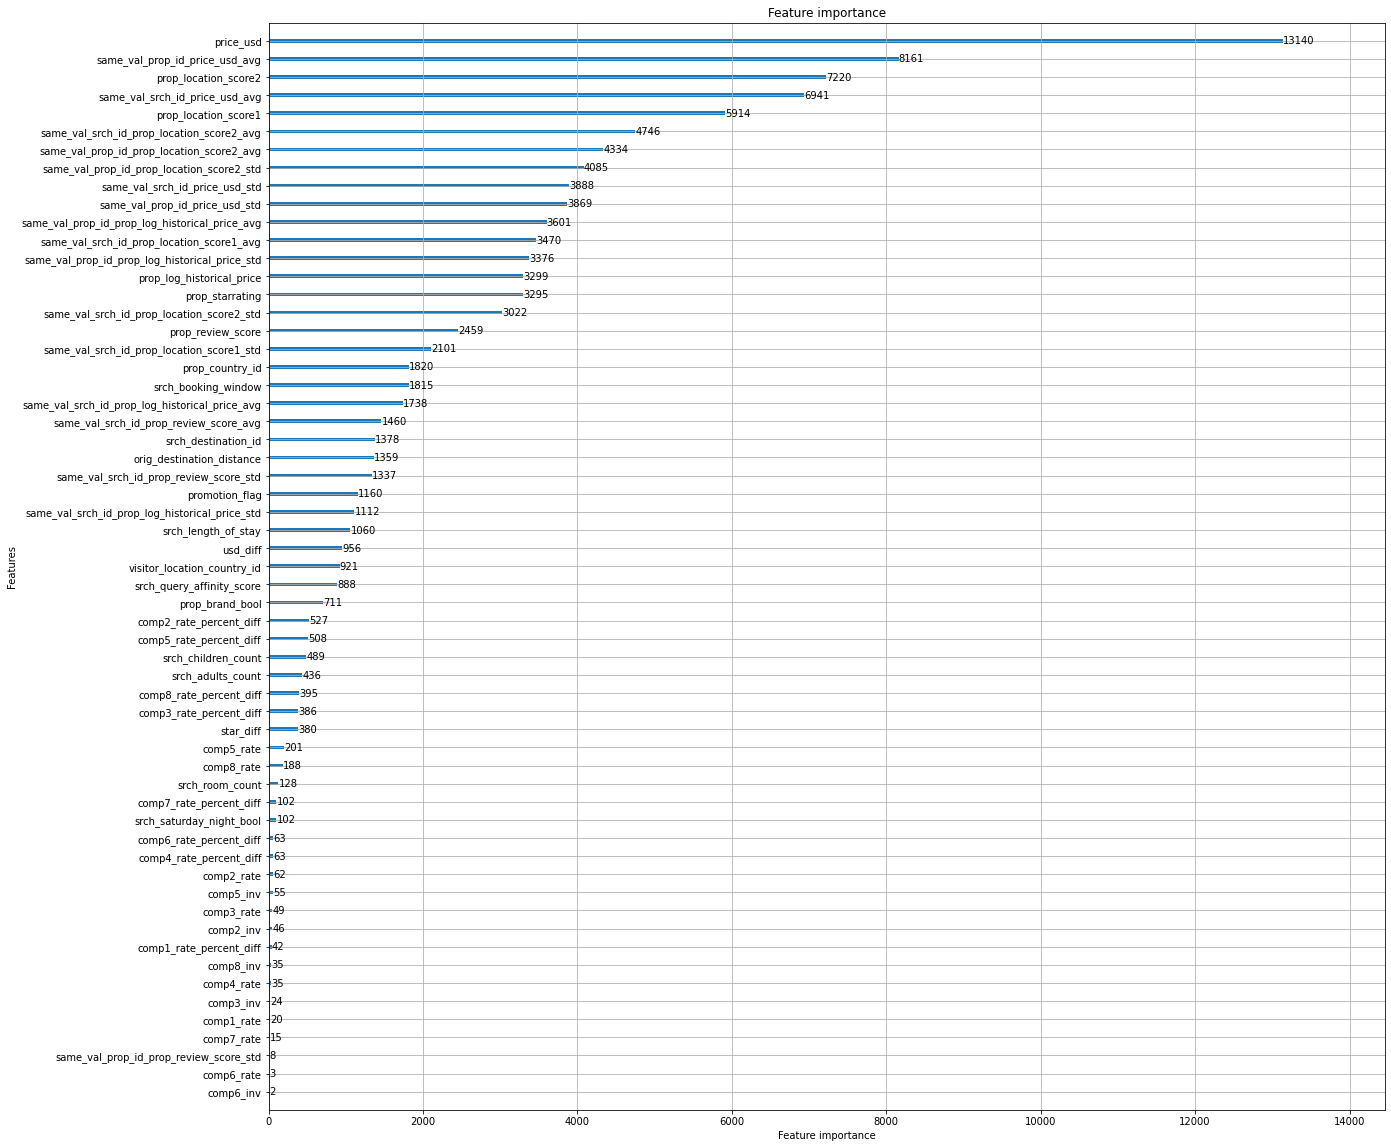

In [ ]:
ax = lgbm.plot_importance(model)
fig = ax.figure
fig.set_size_inches(20,20)

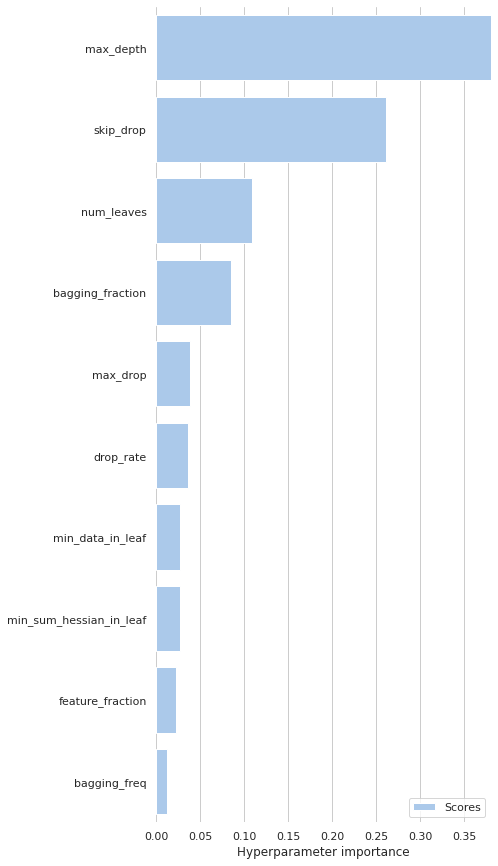

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame()
df['Labels'] = ['max_depth', 'skip_drop', 'num_leaves', 'bagging_fraction', 'max_drop', 'drop_rate','min_data_in_leaf', 'min_sum_hessian_in_leaf', 'feature_fraction', 'bagging_freq']
df['Scores'] = [0.3804, 0.26148, 0.109353, 0.085282, 0.03840323, 0.0362298, 0.027489, 0.026811, 0.0221488, 0.0123034]

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="Scores", y="Labels", data=df,
            label="Scores", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, np.max(df.Scores.values)), ylabel="",
       xlabel="Hyperparameter importance")
sns.despine(left=True, bottom=True)

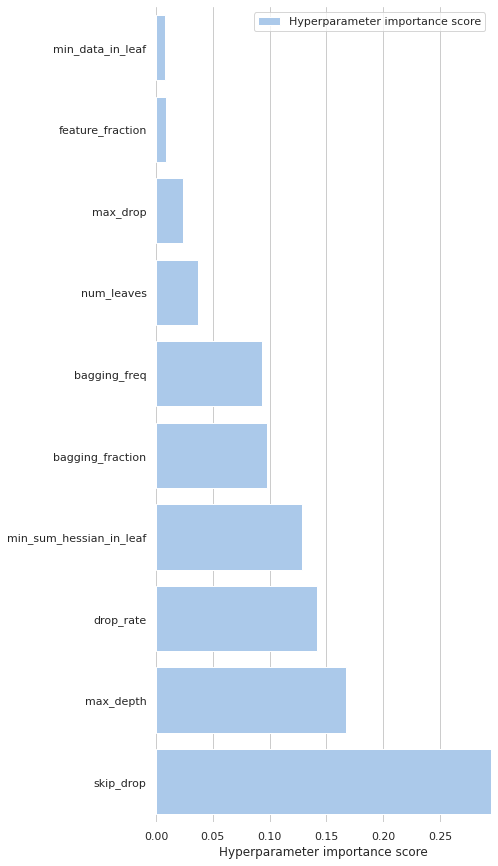

In [ ]:
df = pd.DataFrame()
df['Labels'] = ['min_data_in_leaf', 'feature_fraction', 'max_drop', 'num_leaves',
                    'bagging_freq', 'bagging_fraction', 'min_sum_hessian_in_leaf',
                    'drop_rate', 'max_depth', 'skip_drop']
df['Scores'] = [0.007604838327161177, 0.009162770200641612, 0.02395926370750218, 0.03714472276159001, 0.0928937044473018, 0.0976525495552811, 0.12843841800389105, 0.1413592241256825, 0.16690539843017663, 0.2948791104407719]


sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x="Scores", y="Labels", data=df,
            label="Hyperparameter importance score", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, np.max(df.Scores.values)), ylabel="",
       xlabel="Hyperparameter importance score")
sns.despine(left=True, bottom=True)

